<a href="https://colab.research.google.com/github/2SEHI/Factory-Anomaly-Analysis/blob/main/2_PCA%EC%99%80_RandomForest(VIF).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 확인내용
- VIF계수를 이용하여 제거한 피처를 이용
- 정규화
- PCA주성분 분석 결과
- RandomForest 훈련

# 3가지의 정규화를 이용한 PCA주성분 분석결과 비교
- 데이터 스케일링은 MinMaxScaler, StandardScaler, LogScaler 3가지를 확인해봄

## 1.데이터 스케일링의 종류와 개념

### 1) MinMaxScaler
- 모든 feature를 0~1 사이의 값으로 조정
- 단점 : 이상치가 있다면, 매우 좁은 범위로 압출될 수 있음

### 2) StandardScaler를 이용한 PCA주성분 분석
- 평균과 표준편차를 이용 (x - mean)/(std_deviation)
- 단점 : 이상치가 있으면 변환된 데이터 확산이 매우 달라져 균형잡힌 척도 보장 X
- 넓게 분포된 데이터 보다는 모여진 데이터가 예측률이 좋다



### 3) RobustScaler를 이용한 PCA주성분 분석
- Standard Scaler 와 비슷하지만 평균대신 중앙값 사용 => 극단값(이상치, outlier)에 영향을 받지 않는다


## 2.공통 모듈 임포트

In [ ]:
# colab에서 실행시 matplotlib에 한글을 표시하기 위해서 본 셀을 실행후 runtime을 재시작해야 함
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os
from scipy import stats
import seaborn as sns
# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Display_Sensor_Anomaly_Analysis"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
 
## colab용 글씨체 설정
plt.rc('font', family='NanumBarunGothic') 

## local jupyter 용 글씨체 설정
# font_path = "C:\Windows\Fonts\malgun.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# mpl.rc('font', family=font)

import warnings
warnings.filterwarnings(action='ignore')

np.random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 레이블 데이터 불러오기

In [ ]:
working_dir = '/content/drive/MyDrive/Colab Notebooks/k-digital/[Project]Display_Sensor_Anomaly_Analysis/data/'
fact_lr_labels = pd.read_csv(working_dir + 'fact_lr_labels.csv', index_col=0)
y_data = fact_lr_labels.iloc[:, 0:1]
print(y_data.shape)
print(y_data)

(8145, 1)
                   L.RD
dat...date.name.       
2016-01-01 07     0.025
2016-01-01 08     0.000
2016-01-01 09     0.016
2016-01-01 10     0.000
2016-01-01 11     0.000
...                 ...
2016-12-31 19     0.000
2016-12-31 20     0.010
2016-12-31 21     0.017
2016-12-31 22     0.000
2016-12-31 23     0.000

[8145 rows x 1 columns]


## 3.함수 생성

### 1) 데이터 스케일링결과를 반환하는 함수

In [ ]:
def scale(feature_data):
    from sklearn.preprocessing import MinMaxScaler
    minMaxScaler = MinMaxScaler()
    %time print(minMaxScaler.fit(feature_data))
    feature_data_minMaxScaled =  pd.DataFrame(minMaxScaler.transform(feature_data), columns=feature_data.columns, index=feature_data.index)

    # from sklearn.preprocessing import MaxAbsScaler
    # maxAbsScaler = MaxAbsScaler()
    # %time print(maxAbsScaler.fit(feature_data))
    # feature_data_maxAbsScaled = pd.DataFrame(maxAbsScaler.transform(feature_data), columns=feature_data.columns, index=feature_data.index)

    from sklearn.preprocessing import StandardScaler
    standardScaler = StandardScaler()
    %time print(standardScaler.fit(feature_data))
    feature_data_standardScaled = pd.DataFrame(standardScaler.transform(feature_data), columns=feature_data.columns, index=feature_data.index)

    from sklearn.preprocessing import RobustScaler
    robustScaler = RobustScaler()
    %time print(robustScaler.fit(feature_data))
    feature_data_robustScaled = pd.DataFrame(robustScaler.transform(feature_data), columns=feature_data.columns, index=feature_data.index)
    return feature_data_minMaxScaled, feature_data_standardScaled, feature_data_robustScaled

### 2) pca주성분 결과의 누적 기여율이 90%가 되는 피처개수를 구하는 함수

In [ ]:
def get_pca(feature_data, n_components=2):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=n_components)
    pca.fit(feature_data)
    feature_data_pca = pca.transform(feature_data)
    if n_components==2 :
        feature_data_pca =  pd.DataFrame(data=feature_data_pca, columns=['PC1','PC2'], index=feature_data.index)
        print(feature_data_pca)
        sns.scatterplot(x=feature_data_pca.iloc[:,0], y=feature_data_pca.iloc[:,1])
    else :
        draw_elbowpoint(pca)
        # 주성분의 설명력과 기여율 구하기
        result = pd.DataFrame({'설명가능한 분산 비율(고윳값)':pca.explained_variance_,
                    '기여율':pca.explained_variance_ratio_},
                    index=np.array([f"pca{num+1}" for num in range(feature_data_pca.shape[1])]))
        result['누적기여율'] = result['기여율'].cumsum()
        print_cumsum90(result)
        print('<전체 누적기여율>\n', result)

In [ ]:
def print_cumsum90(result):
    result_mask = result['누적기여율'] <= 0.9
    print('누적기여율이 90%가 되는 피처의 수 : ', len(result[result_mask]))
    print(result[result_mask].tail(5))

### 3) Elbow Point그리는 함수

In [ ]:
def draw_elbowpoint(pca):
    plt.figure(figsize=(16, 6))
    plt.plot(pca.explained_variance_ratio_, marker='o', c='blue')
    plt.xlabel("n_components", fontsize=20)
    plt.ylabel("explained_variance_ratio_", fontsize=20)

# 🎈VIF까지 마친 데이터

## 1.피처와 레이블데이터 불러오기
- 피처의 크기 : 8145 rows × 165 columns(dat...date.name.는 index임)
- 레이블의 크기 : 8145 rows × 4 columns

In [ ]:
working_dir = '/content/drive/MyDrive/Colab Notebooks/k-digital/[Project]Display_Sensor_Anomaly_Analysis/data/'
fact_lr_VIF_feature = pd.read_csv(working_dir + 'fact_lr_VIF_feature.csv', index_col=0)

print(fact_lr_VIF_feature.shape)


(8145, 165)


## 2.데이터스케일링

### 1) 데이터스케일링 하기전 피처의 통계정보확인

In [ ]:
fact_lr_VIF_feature.describe()

,X1WOS45106_PV,X1WOS45107_PV,X1WOS45109_PV,DCS_Offset_RPM_M11.1WOS45111_PV,DCS_Offset_RPM_M15.1WOS45115_PV,DAMP.POSITION.0.BAY.CTRL.1TIC33420.PV,DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV,N2.TO.EA1313A.1FI33503A_PV,ROOF.HEATING.Zone.1.1JIC31101.PV,ROOF.HEATING.Zone.2.1JIC31102.PV,ROOF.HEATING.Zone.3.1JIC31103.PV,ROOF.HEATING.Zone.4.1JIC31104.PV,ATM.FLOW.SECT.9.N2.1FIC33415.PV,Gross.width,Left.edge,UPPER.AB6.Z71.TMP.1TIC41601.PV,UPPER.C1..Z157.TMP.1TIC42203.PV,UPPER.C2..Z169.TMP.1TIC42301.PV,LIFT.OUT.ROL.MTR.M1.CUR.1WII40101.PV,LIFT.OUT.ROL.MTR.M2.CUR.1WII40102.PV,LEHR.DRV.MTR..M4.1.CUR.1WII40104.PV,LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV,LEHR.DRV.MTR..M7.1.CUR.1WII40110.PV,LEHR.DRV.MTR..M7.2.CUR.1WII40111.PV,LEHR.DRV.MTR..M8.1.CUR.1WII40112.PV,LEHR.DRV.MTR..M8.2.CUR.1WII40113.PV,LEHR.DRV.MTR..M11.1.CUR.1WII40118.PV,LEHR.DRV.MTR..M12.1.CUR.1WII40120.PV,LEHR.DRV.MTR..M13.1.CUR.1WII40122.PV,LEHR.DRV.MTR..M15.1.CUR.1WII40126.PV,LEHR.DRV.MTR..M16.1.CUR.1WII40128.PV,LEHR.DRV.MTR..M16.2.CUR.1WII40129.PV,LEHR.DRV.MTR..M17.1.CUR.1WII40130.PV,LEHR.DRV.MTR..M18.1.CUR.1WII40132.PV,LEHR.DRV.MTR..M18.2.CUR.1WII40133.PV,LEHR.DRV.MTR..M19.1.CUR.1WII40134.PV,X1WOS45102_PV.1,X1WOS45106_PV.1,DCS_Offset_RPM_M11.1WOS45111_PV.1,DCS_Offset_RPM_M14.1WOS45114_PV.1,...,D_AB3_U_LR,D_AB3_L_LR,D_AB4_L_LR,D_AB5_U_LR,D_AB6_U_LR,D_AB7_U_LR,D_AB8_U_LR,D_AB8_L_LR,D_AB9_U_LR,D_AB10_U_LR,D_AB11_U_LR,D_AB11_L_LR,D_AB2_L_UL,D_AB3_L_UL,D_AB4_L_UL,D_AB7_L_UL,D_AB8_L_UL,D_AB9_L_UL,D_C1_U_LR,D_C1_L_LR,D_C2_L_LR,D_C3_U_LR,D_C4_U_LR,D_C4_L_LR,D_C2_L_UL,D_GLS_AB11_LR,D_GLS_F_LR,D_GLS_RET_LR,S_AB1_AB2_U_L,S_AB2_AB3_U_L,S_AB3_AB4_U_L,S_AB4_AB5_U_L,S_AB5_AB6_U_L,S_AB6_AB7_U_L,S_AB7_AB8_U_L,S_AB9_AB10_U_L,S_AB10_AB11_L_L,S_C1_C2_L_L,S_C2_C3_L_L,S_C3_C4_U_L
count,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,...,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000
mean,-0.000109,-0.000066,-0.000066,-0.000126,0.000195,0.000865,-0.000921,-0.001064,-0.000745,-0.001166,0.000506,-0.000164,-0.002465,0.000362,0.000672,0.000133,0.000599,-0.000518,-0.000462,-0.000374,0.000010,-0.000065,-0.000015,0.000020,-0.002179,0.000004,0.000248,0.000088,0.000015,-0.000738,-0.000007,-0.000013,-0.000010,0.000115,-0.000010,0.000586,-0.001312,0.000114,-0.000012,0.000059,...,0.000414,0.000162,0.000264,0.000042,0.000753,0.001017,0.001362,0.000378,0.001271,0.000974,0.001102,0.001712,-0.000583,0.000253,-0.000464,-0.000169,-0.000120,0.000321,-0.000605,-0.000147,-0.000585,0.000553,0.000667,0.000614,-0.000795,0.000196,0.000196,0.001021,-0.000788,-0.000435,0.000010,0.000490,-0.000193,-0.000032,0.000028,0.000325,-0.000536,-0.000530,-0.000437,0.000242
std,1.000423,1.000427,1.000427,1.000420,1.000407,0.999994,0.999936,0.999770,1.000106,0.999638,1.000281,1.000414,0.996887,1.000346,1.000141,1.000417,1.000221,1.000273,1.000305,1.000348,1.000430,1.000427,1.000430,1.000429,0.996634,1.000430,1.000394,1.000425,1.000430,1.000113,1.000430,1.000430,1.000430,1.000422,1.000430,1.000229,0.999675,1.000360,1.000368,1.000366,...,1.000329,1.000414,1.000388,1.000427,1.000099,0.999827,0.999342,1.000344,0.999486,0.999875,0.999720,0.998717,1.000231,1.000391,1.000302,1.000411,1.000420,1.000369,1.00021

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-90.27735111, -72.22188089, -54.16641067, -36.11094044,
        -18.05547022,   0.        ,  18.05547022,  36.11094044,
         54.16641067,  72.22188089,  90.27735111]),
 <a list of 8145 Lists of Patches objects>)

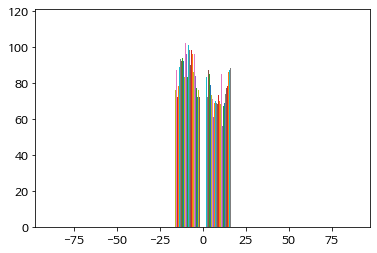

In [ ]:
plt.hist(fact_lr_VIF_feature)

### 2) 데이터 스케일링결과 취득

In [ ]:
X_mm_VIF_scaled, X_std_VIF_scaled, X_rbs_VIF_scaled =  scale(fact_lr_VIF_feature)

MinMaxScaler(copy=True, feature_range=(0, 1))
CPU times: user 6.63 ms, sys: 10 µs, total: 6.64 ms
Wall time: 6.75 ms
StandardScaler(copy=True, with_mean=True, with_std=True)
CPU times: user 19.9 ms, sys: 6.03 ms, total: 25.9 ms
Wall time: 25.9 ms
RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)
CPU times: user 57.3 ms, sys: 9 µs, total: 57.3 ms
Wall time: 57.4 ms


### 3) 데이터스케일링한 후의 통계정보확인


##### MinMaxScaling

In [ ]:
X_mm_VIF_scaled.describe()

,X1WOS45106_PV,X1WOS45107_PV,X1WOS45109_PV,DCS_Offset_RPM_M11.1WOS45111_PV,DCS_Offset_RPM_M15.1WOS45115_PV,DAMP.POSITION.0.BAY.CTRL.1TIC33420.PV,DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV,N2.TO.EA1313A.1FI33503A_PV,ROOF.HEATING.Zone.1.1JIC31101.PV,ROOF.HEATING.Zone.2.1JIC31102.PV,ROOF.HEATING.Zone.3.1JIC31103.PV,ROOF.HEATING.Zone.4.1JIC31104.PV,ATM.FLOW.SECT.9.N2.1FIC33415.PV,Gross.width,Left.edge,UPPER.AB6.Z71.TMP.1TIC41601.PV,UPPER.C1..Z157.TMP.1TIC42203.PV,UPPER.C2..Z169.TMP.1TIC42301.PV,LIFT.OUT.ROL.MTR.M1.CUR.1WII40101.PV,LIFT.OUT.ROL.MTR.M2.CUR.1WII40102.PV,LEHR.DRV.MTR..M4.1.CUR.1WII40104.PV,LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV,LEHR.DRV.MTR..M7.1.CUR.1WII40110.PV,LEHR.DRV.MTR..M7.2.CUR.1WII40111.PV,LEHR.DRV.MTR..M8.1.CUR.1WII40112.PV,LEHR.DRV.MTR..M8.2.CUR.1WII40113.PV,LEHR.DRV.MTR..M11.1.CUR.1WII40118.PV,LEHR.DRV.MTR..M12.1.CUR.1WII40120.PV,LEHR.DRV.MTR..M13.1.CUR.1WII40122.PV,LEHR.DRV.MTR..M15.1.CUR.1WII40126.PV,LEHR.DRV.MTR..M16.1.CUR.1WII40128.PV,LEHR.DRV.MTR..M16.2.CUR.1WII40129.PV,LEHR.DRV.MTR..M17.1.CUR.1WII40130.PV,LEHR.DRV.MTR..M18.1.CUR.1WII40132.PV,LEHR.DRV.MTR..M18.2.CUR.1WII40133.PV,LEHR.DRV.MTR..M19.1.CUR.1WII40134.PV,X1WOS45102_PV.1,X1WOS45106_PV.1,DCS_Offset_RPM_M11.1WOS45111_PV.1,DCS_Offset_RPM_M14.1WOS45114_PV.1,...,D_AB3_U_LR,D_AB3_L_LR,D_AB4_L_LR,D_AB5_U_LR,D_AB6_U_LR,D_AB7_U_LR,D_AB8_U_LR,D_AB8_L_LR,D_AB9_U_LR,D_AB10_U_LR,D_AB11_U_LR,D_AB11_L_LR,D_AB2_L_UL,D_AB3_L_UL,D_AB4_L_UL,D_AB7_L_UL,D_AB8_L_UL,D_AB9_L_UL,D_C1_U_LR,D_C1_L_LR,D_C2_L_LR,D_C3_U_LR,D_C4_U_LR,D_C4_L_LR,D_C2_L_UL,D_GLS_AB11_LR,D_GLS_F_LR,D_GLS_RET_LR,S_AB1_AB2_U_L,S_AB2_AB3_U_L,S_AB3_AB4_U_L,S_AB4_AB5_U_L,S_AB5_AB6_U_L,S_AB6_AB7_U_L,S_AB7_AB8_U_L,S_AB9_AB10_U_L,S_AB10_AB11_L_L,S_C1_C2_L_L,S_C2_C3_L_L,S_C3_C4_U_L
count,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,...,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000
mean,0.988214,0.994107,0.994107,0.982320,0.529466,0.525169,0.610950,0.380635,0.882136,0.658400,0.875308,0.964641,0.205599,0.910308,0.899328,0.359994,0.273476,0.369201,0.275230,0.325675,0.000123,0.502846,0.999724,0.500373,0.037147,0.003712,0.075292,0.008076,0.000222,0.589091,0.999492,0.999754,0.999877,0.013128,0.999877,0.308460,0.455802,0.294897,0.666264,0.201911,...,0.572061,0.139944,0.587133,0.640972,0.692536,0.466686,0.528494,0.734096,0.460561,0.598895,0.596825,0.622731,0.465213,0.667876,0.574495,0.678607,0.476233,0.430342,0.530023,0.519438,0.467738,0.328080,0.147908,0.413764,0.519405,0.464224,0.351680,0.348338,0.567445,0.487100,0.441858,0.373504,0.475686,0.610101,0.545925,0.680393,0.418794,0.344783,0.456452,0.332634
std,0.093284,0.076545,0.076545,0.120092,0.129666,0.355949,0.278701,0.158362,0.135831,0.169708,0.180221,0.184697,0.275895,0.026891,0.032969,0.027423,0.129259,0.096405,0.164278,0.171685,0.011080,0.011209,0.015717,0.015667,0.178202,0.015635,0.260872,0.079100,0.012401,0.478250,0.011077,0.015669,0.011080,0.098121,0.011080,0.451787,0.108320,0.076464,0.025378,0.031673,...,0.107547,0.030724,0.100994,0.101941,0.119709,0.119996,0.097228,0.104138,0.096378,0.109414,0.112630,0.149610,0.141090,0.096304,0.117128,0.120139,0.122956,0.165462,0.126784,0.142875,0.144254,0.143745,0.047157,

(array([[34., 12.,  9., ..., 15.,  9., 20.],
        [34., 11., 15., ..., 12., 11., 19.],
        [33., 12., 12., ..., 13., 11., 20.],
        ...,
        [26., 15.,  9., ...,  7., 10., 21.],
        [25., 16.,  9., ...,  8.,  9., 22.],
        [26., 15.,  9., ...,  8., 10., 21.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 8145 Lists of Patches objects>)

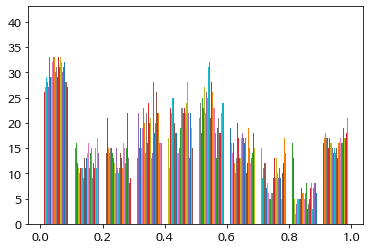

In [ ]:
plt.hist(X_mm_VIF_scaled)

##### StandardScaling

In [ ]:
X_std_VIF_scaled.describe()

,X1WOS45106_PV,X1WOS45107_PV,X1WOS45109_PV,DCS_Offset_RPM_M11.1WOS45111_PV,DCS_Offset_RPM_M15.1WOS45115_PV,DAMP.POSITION.0.BAY.CTRL.1TIC33420.PV,DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV,N2.TO.EA1313A.1FI33503A_PV,ROOF.HEATING.Zone.1.1JIC31101.PV,ROOF.HEATING.Zone.2.1JIC31102.PV,ROOF.HEATING.Zone.3.1JIC31103.PV,ROOF.HEATING.Zone.4.1JIC31104.PV,ATM.FLOW.SECT.9.N2.1FIC33415.PV,Gross.width,Left.edge,UPPER.AB6.Z71.TMP.1TIC41601.PV,UPPER.C1..Z157.TMP.1TIC42203.PV,UPPER.C2..Z169.TMP.1TIC42301.PV,LIFT.OUT.ROL.MTR.M1.CUR.1WII40101.PV,LIFT.OUT.ROL.MTR.M2.CUR.1WII40102.PV,LEHR.DRV.MTR..M4.1.CUR.1WII40104.PV,LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV,LEHR.DRV.MTR..M7.1.CUR.1WII40110.PV,LEHR.DRV.MTR..M7.2.CUR.1WII40111.PV,LEHR.DRV.MTR..M8.1.CUR.1WII40112.PV,LEHR.DRV.MTR..M8.2.CUR.1WII40113.PV,LEHR.DRV.MTR..M11.1.CUR.1WII40118.PV,LEHR.DRV.MTR..M12.1.CUR.1WII40120.PV,LEHR.DRV.MTR..M13.1.CUR.1WII40122.PV,LEHR.DRV.MTR..M15.1.CUR.1WII40126.PV,LEHR.DRV.MTR..M16.1.CUR.1WII40128.PV,LEHR.DRV.MTR..M16.2.CUR.1WII40129.PV,LEHR.DRV.MTR..M17.1.CUR.1WII40130.PV,LEHR.DRV.MTR..M18.1.CUR.1WII40132.PV,LEHR.DRV.MTR..M18.2.CUR.1WII40133.PV,LEHR.DRV.MTR..M19.1.CUR.1WII40134.PV,X1WOS45102_PV.1,X1WOS45106_PV.1,DCS_Offset_RPM_M11.1WOS45111_PV.1,DCS_Offset_RPM_M14.1WOS45114_PV.1,...,D_AB3_U_LR,D_AB3_L_LR,D_AB4_L_LR,D_AB5_U_LR,D_AB6_U_LR,D_AB7_U_LR,D_AB8_U_LR,D_AB8_L_LR,D_AB9_U_LR,D_AB10_U_LR,D_AB11_U_LR,D_AB11_L_LR,D_AB2_L_UL,D_AB3_L_UL,D_AB4_L_UL,D_AB7_L_UL,D_AB8_L_UL,D_AB9_L_UL,D_C1_U_LR,D_C1_L_LR,D_C2_L_LR,D_C3_U_LR,D_C4_U_LR,D_C4_L_LR,D_C2_L_UL,D_GLS_AB11_LR,D_GLS_F_LR,D_GLS_RET_LR,S_AB1_AB2_U_L,S_AB2_AB3_U_L,S_AB3_AB4_U_L,S_AB4_AB5_U_L,S_AB5_AB6_U_L,S_AB6_AB7_U_L,S_AB7_AB8_U_L,S_AB9_AB10_U_L,S_AB10_AB11_L_L,S_C1_C2_L_L,S_C2_C3_L_L,S_C3_C4_U_L
count,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,...,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03,8.145000e+03
mean,4.698029e-15,3.483896e-15,5.001824e-15,-1.035169e-14,-2.851978e-14,-3.831380e-15,-1.324520e-14,-3.222714e-14,-5.896608e-14,1.920423e-14,-1.771349e-14,4.904439e-15,2.026977e-14,-1.554258e-15,3.290009e-15,-1.059926e-16,-4.985849e-16,1.369616e-16,-1.116589e-14,1.311399e-15,1.255188e-15,-1.395637e-15,5.547094e-16,2.413410e-15,-1.624194e-14,-3.506846e-16,3.648336e-14,2.851668e-15,-1.511110e-15,-1.318078e-14,7.773005e-16,-3.569974e-17,-5.616457e-16,2.316922e-14,-7.134376e-16,4.036586e-14,-2.219192e-14,-4.038540e-15,2.415907e-15,8.714603e-15,...,-1.957373e-17,-1.664823e-16,-3.474882e-16,5.373234e-17,1.141301e-16,-4.356382e-17,-1.061016e-16,-2.998488e-16,-2.805750e-16,-4.290681e-16,-5.066543e-16,3.509095e-16,-5.185539e-16,4.339582e-16,-1.099387e-16,-1.522007e-16,-4.853051e-17,-9.876214e-16,4.454387e-16,-3.696654e-16,-3.429628e-16,1.041156e-15,-1.805254e-16,-1.968550e-16,-5.475465e-16,-3.791320e-16,1.958259e-16,1.215316e-16,3.930830e-16,4.727137e-16,6.795430e-17,7.650929e-17,1.051440e-16,2.657941e-16,-7.574665e-16,-9.575588e-17,7.183668e-16,5.480099e-16,-1.037503e-16,-4.838262e-16
std,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e

In [ ]:
X_std_VIF_scaled.min().min()

-90.24411338142781

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-9.02441134e+01, -7.21952907e+01, -5.41464680e+01, -3.60976454e+01,
        -1.80488227e+01,  1.42108547e-14,  1.80488227e+01,  3.60976454e+01,
         5.41464680e+01,  7.21952907e+01,  9.02441134e+01]),
 <a list of 8145 Lists of Patches objects>)

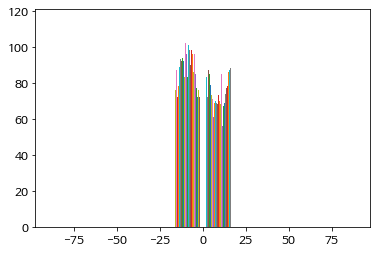

In [ ]:
plt.hist(X_std_VIF_scaled)

##### RobustScaling

In [ ]:
X_rbs_VIF_scaled

,X1WOS45106_PV,X1WOS45107_PV,X1WOS45109_PV,DCS_Offset_RPM_M11.1WOS45111_PV,DCS_Offset_RPM_M15.1WOS45115_PV,DAMP.POSITION.0.BAY.CTRL.1TIC33420.PV,DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV,N2.TO.EA1313A.1FI33503A_PV,ROOF.HEATING.Zone.1.1JIC31101.PV,ROOF.HEATING.Zone.2.1JIC31102.PV,ROOF.HEATING.Zone.3.1JIC31103.PV,ROOF.HEATING.Zone.4.1JIC31104.PV,ATM.FLOW.SECT.9.N2.1FIC33415.PV,Gross.width,Left.edge,UPPER.AB6.Z71.TMP.1TIC41601.PV,UPPER.C1..Z157.TMP.1TIC42203.PV,UPPER.C2..Z169.TMP.1TIC42301.PV,LIFT.OUT.ROL.MTR.M1.CUR.1WII40101.PV,LIFT.OUT.ROL.MTR.M2.CUR.1WII40102.PV,LEHR.DRV.MTR..M4.1.CUR.1WII40104.PV,LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV,LEHR.DRV.MTR..M7.1.CUR.1WII40110.PV,LEHR.DRV.MTR..M7.2.CUR.1WII40111.PV,LEHR.DRV.MTR..M8.1.CUR.1WII40112.PV,LEHR.DRV.MTR..M8.2.CUR.1WII40113.PV,LEHR.DRV.MTR..M11.1.CUR.1WII40118.PV,LEHR.DRV.MTR..M12.1.CUR.1WII40120.PV,LEHR.DRV.MTR..M13.1.CUR.1WII40122.PV,LEHR.DRV.MTR..M15.1.CUR.1WII40126.PV,LEHR.DRV.MTR..M16.1.CUR.1WII40128.PV,LEHR.DRV.MTR..M16.2.CUR.1WII40129.PV,LEHR.DRV.MTR..M17.1.CUR.1WII40130.PV,LEHR.DRV.MTR..M18.1.CUR.1WII40132.PV,LEHR.DRV.MTR..M18.2.CUR.1WII40133.PV,LEHR.DRV.MTR..M19.1.CUR.1WII40134.PV,X1WOS45102_PV.1,X1WOS45106_PV.1,DCS_Offset_RPM_M11.1WOS45111_PV.1,DCS_Offset_RPM_M14.1WOS45114_PV.1,...,D_AB3_U_LR,D_AB3_L_LR,D_AB4_L_LR,D_AB5_U_LR,D_AB6_U_LR,D_AB7_U_LR,D_AB8_U_LR,D_AB8_L_LR,D_AB9_U_LR,D_AB10_U_LR,D_AB11_U_LR,D_AB11_L_LR,D_AB2_L_UL,D_AB3_L_UL,D_AB4_L_UL,D_AB7_L_UL,D_AB8_L_UL,D_AB9_L_UL,D_C1_U_LR,D_C1_L_LR,D_C2_L_LR,D_C3_U_LR,D_C4_U_LR,D_C4_L_LR,D_C2_L_UL,D_GLS_AB11_LR,D_GLS_F_LR,D_GLS_RET_LR,S_AB1_AB2_U_L,S_AB2_AB3_U_L,S_AB3_AB4_U_L,S_AB4_AB5_U_L,S_AB5_AB6_U_L,S_AB6_AB7_U_L,S_AB7_AB8_U_L,S_AB9_AB10_U_L,S_AB10_AB11_L_L,S_C1_C2_L_L,S_C2_C3_L_L,S_C3_C4_U_L
dat...date.name.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 07,0.0,0.0,0.0,0.0,0.0,-0.5,-1.685714,0.000000,0.000000,-3.5,-2.561673,0.0,0.0,2.636364,4.142857,1.243768,-0.346524,0.363871,3.046630,2.499511,0.0,0.0,0.0,0.0,19668.018513,-0.233341,0.117392,0.0,0.0,0.00008,0.0,0.0,0.0,0.00000,0.0,1.00049,-2.0,5.606849,5.255927,99999.992629,...,0.483285,-2.108388,0.086420,-1.025292,-0.427272,0.164784,-0.535596,-2.343393,-0.359471,1.040615,0.397005,1.423470,-1.760593,2.124619,1.995960,-0.530660,1.877907,1.157748,0.852578,-0.527807,0.322840,1.761098,0.703352,1.394488,0.829609,-0.257411,0.298523,-0.800993,-0.057963,-1.243319,0.878179,0.273519,-0.533352,-0.411844,0.997314,-0.436310,-1.335094,-0.139441,0.484925,2.262418
2016-01-01 08,0.0,0.0,0.0,0.0,0.0,-0.5,-1.685714,0.000000,0.000000,-3.5,-2.561673,0.0,0.0,2.659091,4.071429,1.064337,-0.360882,0.402270,3.050728,1.999531,0.0,0.0,0.0,0.0,16872.015881,-0.233341,0.117392,0.0,0.0,0.00008,0.0,0.0,0.0,0.00000,0.0,1.00049,-3.0,0.021904,0.000026,0.000000,...,0.526915,-2.052321,0.153346,-1.044366,-0.296226,0.447606,-0.441465,-2.262279,-0.304377,1.049977,0.327884,1.400119,-1.737724,2.132629,1.883207,-0.426205,1.796968,1.207636,0.812290,-0.697292,0.513944,1.770477,0.620976,1.272469,0.821823,-0.159071,0.509679,-0.441078,-0.094678,-1.265372,0.940618,0.252933,-0.580457,-0.524989,0.811466,-0.404700,-1.254220,-0.391436,0.557442,2.349330
2016-01-01 09,0.0,0.0,0.0,0.0,0.0,-0.5,-1.685714,0.000000,0.000000,-3.5,-2.561673,0.0,0.0,2.681818,4.142857,0.811369,-0.365747,0.395995,2.249512,1.999511,0.0,0.0,0.0,0.0,19961.018789,-0.233341,0.117392,0.0,0.0,0.00008,0.0,0.0,0.0,64.09463,0.0,1.00049,-3.0,0.021904,0.000026,0.000000,...,0.621829,-2.109870,0.368224,-1.030993,-0.203708,0.452186,-0.396231,-2.238578,-0.334992,1.117338,0.339014,1.517522,-1.765934,2.335500,1.774353,-0.434916,1.832003,1.175582,0.902951,-0.649743,0.411182,1.808561,0.535745,1.076150,0.998973,-0.008264,0.720919,-0.297622,-0.089016,-1.341212,0.966141,0.505111,-0.456821,-0.551165,0.576893,-0.430856,-1.215449,-0.113681,0.413800,2.333593
2016-01-01 10,0.0,0.0,0.0,0.0,0.0,-0.5,-1.685714,0.000000,0.000000,-3.5,-2.561673,0.0,0.0,2.681818,4.214286,0.555143,-0.390610,0.383578,3.496154,1.999511,0.0,0.0,0.0,0.0,18747.617

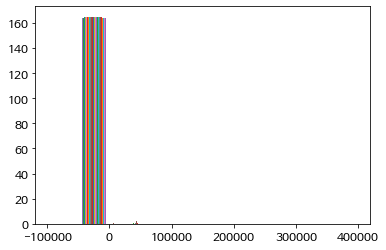

In [ ]:
plt.hist(X_rbs_VIF_scaled)
plt.show()

In [ ]:
X_rbs_VIF_scaled.describe()

,X1WOS45106_PV,X1WOS45107_PV,X1WOS45109_PV,DCS_Offset_RPM_M11.1WOS45111_PV,DCS_Offset_RPM_M15.1WOS45115_PV,DAMP.POSITION.0.BAY.CTRL.1TIC33420.PV,DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV,N2.TO.EA1313A.1FI33503A_PV,ROOF.HEATING.Zone.1.1JIC31101.PV,ROOF.HEATING.Zone.2.1JIC31102.PV,ROOF.HEATING.Zone.3.1JIC31103.PV,ROOF.HEATING.Zone.4.1JIC31104.PV,ATM.FLOW.SECT.9.N2.1FIC33415.PV,Gross.width,Left.edge,UPPER.AB6.Z71.TMP.1TIC41601.PV,UPPER.C1..Z157.TMP.1TIC42203.PV,UPPER.C2..Z169.TMP.1TIC42301.PV,LIFT.OUT.ROL.MTR.M1.CUR.1WII40101.PV,LIFT.OUT.ROL.MTR.M2.CUR.1WII40102.PV,LEHR.DRV.MTR..M4.1.CUR.1WII40104.PV,LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV,LEHR.DRV.MTR..M7.1.CUR.1WII40110.PV,LEHR.DRV.MTR..M7.2.CUR.1WII40111.PV,LEHR.DRV.MTR..M8.1.CUR.1WII40112.PV,LEHR.DRV.MTR..M8.2.CUR.1WII40113.PV,LEHR.DRV.MTR..M11.1.CUR.1WII40118.PV,LEHR.DRV.MTR..M12.1.CUR.1WII40120.PV,LEHR.DRV.MTR..M13.1.CUR.1WII40122.PV,LEHR.DRV.MTR..M15.1.CUR.1WII40126.PV,LEHR.DRV.MTR..M16.1.CUR.1WII40128.PV,LEHR.DRV.MTR..M16.2.CUR.1WII40129.PV,LEHR.DRV.MTR..M17.1.CUR.1WII40130.PV,LEHR.DRV.MTR..M18.1.CUR.1WII40132.PV,LEHR.DRV.MTR..M18.2.CUR.1WII40133.PV,LEHR.DRV.MTR..M19.1.CUR.1WII40134.PV,X1WOS45102_PV.1,X1WOS45106_PV.1,DCS_Offset_RPM_M11.1WOS45111_PV.1,DCS_Offset_RPM_M14.1WOS45114_PV.1,...,D_AB3_U_LR,D_AB3_L_LR,D_AB4_L_LR,D_AB5_U_LR,D_AB6_U_LR,D_AB7_U_LR,D_AB8_U_LR,D_AB8_L_LR,D_AB9_U_LR,D_AB10_U_LR,D_AB11_U_LR,D_AB11_L_LR,D_AB2_L_UL,D_AB3_L_UL,D_AB4_L_UL,D_AB7_L_UL,D_AB8_L_UL,D_AB9_L_UL,D_C1_U_LR,D_C1_L_LR,D_C2_L_LR,D_C3_U_LR,D_C4_U_LR,D_C4_L_LR,D_C2_L_UL,D_GLS_AB11_LR,D_GLS_F_LR,D_GLS_RET_LR,S_AB1_AB2_U_L,S_AB2_AB3_U_L,S_AB3_AB4_U_L,S_AB4_AB5_U_L,S_AB5_AB6_U_L,S_AB6_AB7_U_L,S_AB7_AB8_U_L,S_AB9_AB10_U_L,S_AB10_AB11_L_L,S_C1_C2_L_L,S_C2_C3_L_L,S_C3_C4_U_L
count,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,...,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000
mean,-0.126403,-0.077022,-0.077022,-0.147278,0.227337,0.037753,-0.348129,0.217684,-0.040516,-0.537201,-0.265131,-0.191523,0.027993,-0.036461,-0.056590,0.092256,-0.197623,-0.177503,0.513791,0.627884,0.011085,-5.076180,-0.017595,0.023851,742.931773,0.004179,0.288731,0.102143,0.017912,-0.410829,-0.008724,-0.015678,-0.011085,3.357595,-0.011085,0.308611,-0.619227,0.120130,-0.015831,1267.710650,...,-0.043548,-0.118992,-0.057943,-0.157300,-0.121126,-0.015443,-0.004618,-0.133078,-0.085740,0.054332,-0.056105,-0.022264,-0.076176,-0.098745,-0.054165,-0.142888,0.046647,0.130099,-0.266619,0.149657,0.061501,0.064798,0.063801,0.090980,-0.018899,-0.006632,-0.032069,0.059439,-0.077437,0.236326,0.211489,0.187075,0.114734,0.007500,0.019510,-0.027131,0.021858,0.021837,0.114202,0.107273
std,1.000423,1.000427,1.000427,1.000420,1.000407,0.533923,0.883880,0.999770,0.814989,0.763687,1.000281,1.000414,1.379474,0.883129,1.726144,1.357756,0.548893,0.887282,0.903579,0.858427,1.000430,67.437178,1.000430,1.000429,3564.051997,1.000430,1.000394,1.000425,1.000430,0.478250,1.000430,1.000430,1.000430,25.094764,1.000430,0.452009,1.516365,1.000360,1.000368,15824.318432,...,0.914858,1.114695,0.906838,1.002160,0.892360,0.901415,0.764036,0.854398,0.848370,0.833962,0.675433,0.705335,0.880041,1.040166,1.095618,0.936165,0.8096

## 3.주성분분석

### 1) 스케일링 안한 데이터

#### 누적기여율과 elbowPoint확인

누적기여율이 90%가 되는 피처의 수 :  57
       설명가능한 분산 비율(고윳값)       기여율     누적기여율
pca53          0.751401  0.004554  0.883674
pca54          0.707291  0.004287  0.887961
pca55          0.685500  0.004155  0.892116
pca56          0.670267  0.004063  0.896178
pca57          0.614168  0.003723  0.899901
<전체 누적기여율>
         설명가능한 분산 비율(고윳값)       기여율     누적기여율
pca1           25.034596  0.151738  0.151738
pca2           14.227044  0.086232  0.237970
pca3            9.620864  0.058313  0.296283
pca4            7.715375  0.046764  0.343047
pca5            6.119732  0.037092  0.380140
...                  ...       ...       ...
pca161          0.016936  0.000103  0.999674
pca162          0.015368  0.000093  0.999767
pca163          0.015149  0.000092  0.999859
pca164          0.012510  0.000076  0.999935
pca165          0.010710  0.000065  1.000000

[165 rows x 3 columns]


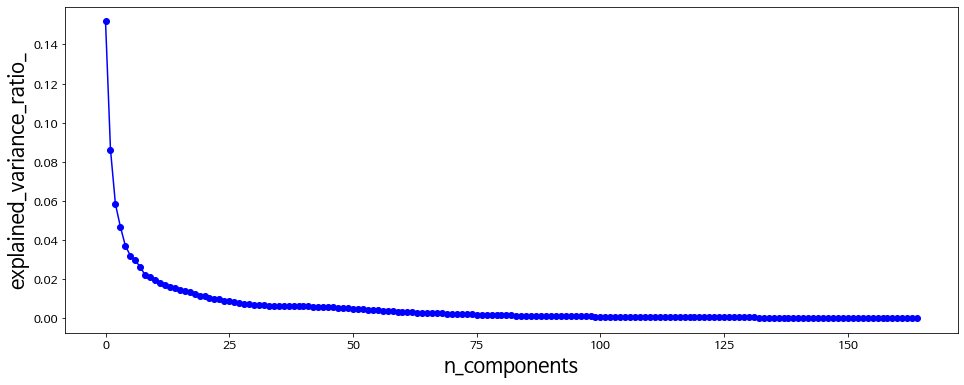

In [ ]:
get_pca(fact_lr_VIF_feature, len(fact_lr_VIF_feature.columns))

#### n_components 2개 설정시 PC1 과 PC2의 관계

                        PC1       PC2
dat...date.name.                     
2016-01-01 07     14.233546  3.440191
2016-01-01 08     13.258277  3.225914
2016-01-01 09     14.291300  3.284065
2016-01-01 10     14.082900  3.561755
2016-01-01 11     15.370156  3.841754
...                     ...       ...
2016-12-31 19     -0.660706  5.670009
2016-12-31 20     -0.212526  6.012899
2016-12-31 21     -0.383798  5.508108
2016-12-31 22      0.113667  5.910955
2016-12-31 23     -0.098277  5.875151

[8145 rows x 2 columns]


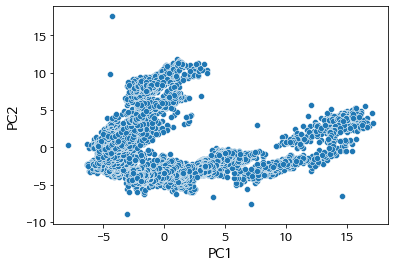

In [ ]:
get_pca(fact_lr_VIF_feature)

### 2) MinMaxScaling

#### 누적기여율과 elbowPoint확인

누적기여율이 90%가 되는 피처의 수 :  29
       설명가능한 분산 비율(고윳값)       기여율     누적기여율
pca25          0.018575  0.005846  0.876048
pca26          0.017928  0.005642  0.881690
pca27          0.016154  0.005084  0.886774
pca28          0.015712  0.004944  0.891718
pca29          0.015173  0.004775  0.896493
<전체 누적기여율>
         설명가능한 분산 비율(고윳값)       기여율     누적기여율
pca1            0.824083  0.259334  0.259334
pca2            0.422667  0.133011  0.392345
pca3            0.313368  0.098615  0.490960
pca4            0.170837  0.053761  0.544721
pca5            0.119679  0.037662  0.582383
...                  ...       ...       ...
pca161          0.000039  0.000012  0.999976
pca162          0.000025  0.000008  0.999983
pca163          0.000024  0.000007  0.999991
pca164          0.000016  0.000005  0.999996
pca165          0.000012  0.000004  1.000000

[165 rows x 3 columns]


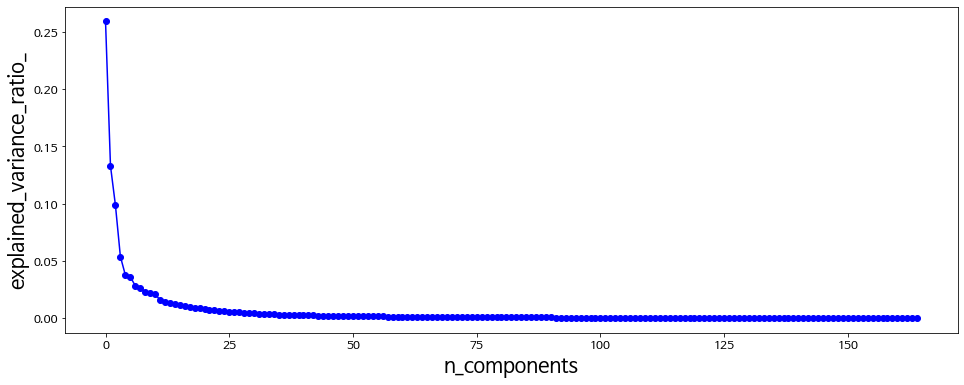

In [ ]:
get_pca(X_mm_VIF_scaled, len(X_mm_VIF_scaled.columns))

#### n_components 2개 설정시 PC1 과 PC2의 관계

                       PC1       PC2
dat...date.name.                    
2016-01-01 07     1.996534  0.070116
2016-01-01 08     1.957710  0.062295
2016-01-01 09     2.004926  0.047892
2016-01-01 10     2.019352  0.072935
2016-01-01 11     2.090577  0.072062
...                    ...       ...
2016-12-31 19     0.216996  1.632463
2016-12-31 20     0.256185  1.634277
2016-12-31 21     0.266630  1.618659
2016-12-31 22     0.301194  1.657902
2016-12-31 23     0.293079  1.638308

[8145 rows x 2 columns]


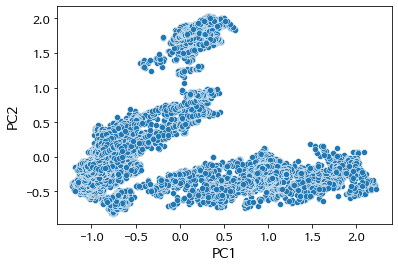

In [ ]:
get_pca(X_mm_VIF_scaled)

### 3) StandardScaling

#### 누적기여율과 elbowPoint확인

누적기여율이 90%가 되는 피처의 수 :  57
       설명가능한 분산 비율(고윳값)       기여율     누적기여율
pca53          0.751385  0.004553  0.883662
pca54          0.707362  0.004287  0.887949
pca55          0.685567  0.004154  0.892103
pca56          0.670557  0.004063  0.896167
pca57          0.614292  0.003723  0.899889
<전체 누적기여율>
         설명가능한 분산 비율(고윳값)       기여율     누적기여율
pca1           25.035410  0.151711  0.151711
pca2           14.242599  0.086308  0.238019
pca3            9.632294  0.058370  0.296390
pca4            7.716688  0.046762  0.343152
pca5            6.119540  0.037084  0.380235
...                  ...       ...       ...
pca161          0.016939  0.000103  0.999674
pca162          0.015368  0.000093  0.999767
pca163          0.015145  0.000092  0.999859
pca164          0.012513  0.000076  0.999935
pca165          0.010710  0.000065  1.000000

[165 rows x 3 columns]


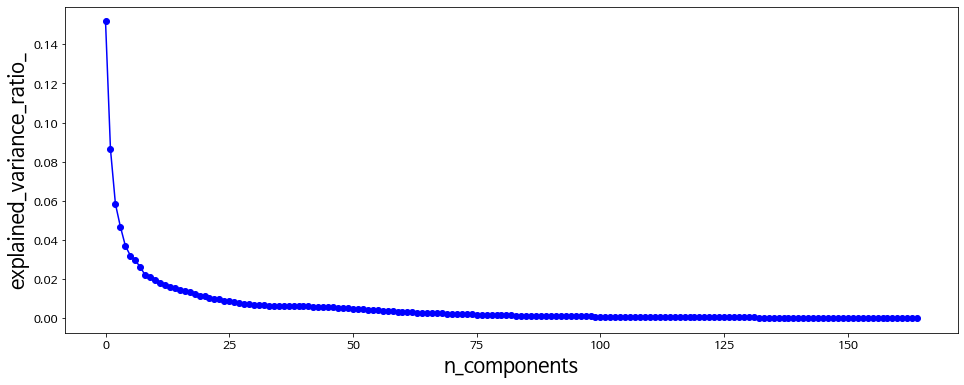

In [ ]:
get_pca(X_std_VIF_scaled, len(X_std_VIF_scaled.columns))

#### n_components 2개 설정시 PC1 과 PC2의 관계

                        PC1       PC2
dat...date.name.                     
2016-01-01 07     14.234109  3.433020
2016-01-01 08     13.258980  3.218861
2016-01-01 09     14.292343  3.276014
2016-01-01 10     14.083612  3.553976
2016-01-01 11     15.371416  3.832949
...                     ...       ...
2016-12-31 19     -0.654109  5.707974
2016-12-31 20     -0.205520  6.053334
2016-12-31 21     -0.376069  5.548042
2016-12-31 22      0.122695  5.951191
2016-12-31 23     -0.090187  5.912868

[8145 rows x 2 columns]


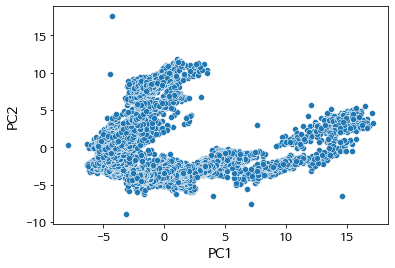

In [ ]:
get_pca(X_std_VIF_scaled)

### 4) RobustScaling

#### 누적기여율과 elbowPoint확인

누적기여율이 90%가 되는 피처의 수 :  0
Empty DataFrame
Columns: [설명가능한 분산 비율(고윳값), 기여율, 누적기여율]
Index: []
<전체 누적기여율>
         설명가능한 분산 비율(고윳값)           기여율     누적기여율
pca1        2.504110e+08  9.512326e-01  0.951233
pca2        1.270566e+07  4.826481e-02  0.999497
pca3        1.250997e+05  4.752144e-04  0.999973
pca4        4.546603e+03  1.727111e-05  0.999990
pca5        1.279461e+03  4.860269e-06  0.999995
...                  ...           ...       ...
pca161      1.020557e-02  3.876773e-11  1.000000
pca162      9.509161e-03  3.612231e-11  1.000000
pca163      8.423451e-03  3.199804e-11  1.000000
pca164      7.237756e-03  2.749396e-11  1.000000
pca165      6.361437e-03  2.416509e-11  1.000000

[165 rows x 3 columns]


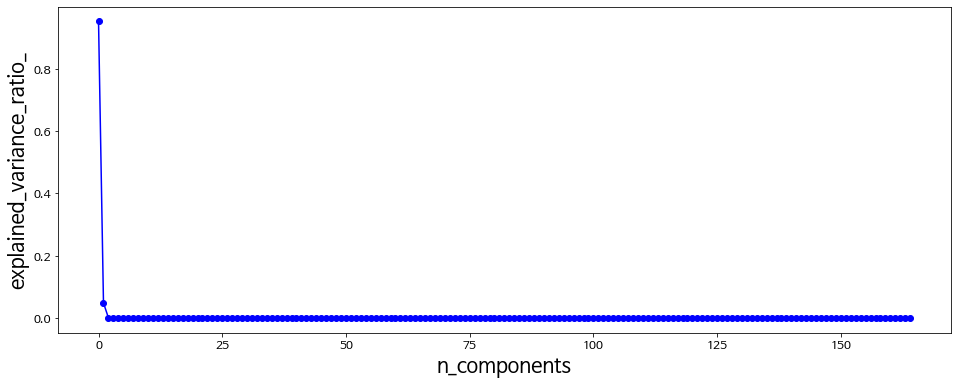

In [ ]:
get_pca(X_rbs_VIF_scaled, len(X_rbs_VIF_scaled.columns))

#### n_components 2개 설정시 PC1 과 PC2의 관계

                           PC1           PC2
dat...date.name.                            
2016-01-01 07     98678.349797  19199.552678
2016-01-01 08     -1313.311217  16120.007807
2016-01-01 09     -1322.056604  19208.483139
2016-01-01 10     -1318.621284  17995.223404
2016-01-01 11     -1322.169598  19247.771322
...                        ...           ...
2016-12-31 19     -1265.781533   -739.604578
2016-12-31 20     -1265.751370   -739.123578
2016-12-31 21     -1283.035120   5493.079694
2016-12-31 22     -1302.502019  12367.664389
2016-12-31 23     -1284.805041   6118.152342

[8145 rows x 2 columns]


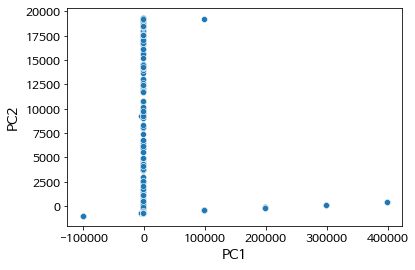

In [ ]:
get_pca(X_rbs_VIF_scaled)

# 데이터 스케일링 선택 - MinMaxScaling으로 결정
- Standard Scaler 사용시 이상치의 영향을 크게 받아 데이터가 -90 ~ +90 사이로 고르지 않게 분포하고, MinMax Scaler를 사용하면 데이터가 고르게 분포하였기 때문

# RandomForest 모델링

## 1.공통 모듈 임포트

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import graphviz
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV

## 2.함수 생성

### 1) show_labels_cnt : 양품과 불량품의 비율 그래프를 생성하는 함수

In [ ]:
def show_all_labels_cnt(y_df):
    rows = 2
    cols = 2
    # constrained_layout : 플롯간의 간격을 자동으로 조절
    fig, ax = plt.subplots(nrows=rows, ncols=cols,constrained_layout=True, figsize=(10,8))
    for i in range(len(y_df.columns)):
        # 양품의 개수
        good_RD = y_df.iloc[:,i].value_counts()[0]
        # 불량품의 개수
        bad_RD = y_df.iloc[:,i].value_counts()[1]
        # 카운트 그래프
        a = sns.countplot(x=y_df.columns[i], data=y_df, ax=ax[i//2, i%2])
        cnt = 0
        for p in a.patches:
            height = p.get_height() # 그래프의 높이(개수를 그래프위에 표시하기 위해 필요)
            # 개수를 그래프에 표시
            a.text(p.get_x()+p.get_width()/2., height + 0.1, y_df.iloc[:,i].value_counts()[cnt],ha="center")
            cnt += 1
    plt.show()

In [ ]:
def show_one_labels_cnt(new_label_df):
    for i in range(len(new_label_df.columns)):
        plt.figure(figsize=(8,6))
        good_RD = new_label_df.iloc[:,i].value_counts()[0]
        bad_RD = new_label_df.iloc[:,i].value_counts()[1]
        ax = sns.countplot(x=new_label_df.columns[i], data=new_label_df)
        ax.set_xticklabels(['양품', '불량품'])
        ax.set_xlabel('양품/불량품')
        ax.text(-0.1,good_RD + 5,good_RD, fontdict=dict(fontsize=20))
        ax.text(0.9,bad_RD + 5,bad_RD, fontdict=dict(fontsize=20))
        plt.title(f"{new_label_df.columns[i]}의 양품/ 불량품 갯수")
        plt.show()

### 2) get_clf_eval : 분류에서의 평가지표를 출력해주는 함수

In [ ]:
## 분류에서의 평가지표를 출력해주는 함수
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    print('정확도:', accuracy)
    print('정밀도:', precision)
    print('재현율:', recall)
    print('F1:', f1)
    print('AUC:', roc_auc)

### 3) show_feature_label : 피처중요도가 높은 5개의 피처와 레이블과의 관계그래프를 보여주는 함수

In [ ]:
def show_feature_label(ft_top24, y_df):
    y_df = y_df.set_index(X_data.index)
    rows = 1
    cols = 5
    fig, ax = plt.subplots(nrows=rows, ncols=cols,constrained_layout=True, figsize=(28,5))
    cnt=0
    i = ft_top24.index[0]
    for i in ft_top24.index[:5]:
        concatenated = pd.concat([X_data[i], y_df['L.RD']], axis=1)
        concatenated
        sns.scatterplot(data=concatenated, x=i, y= 'L.RD',ax=ax[cnt])
        cnt+=1
    plt.xlabel(i)
    plt.ylabel('target')
    plt.show()

In [ ]:
def show_feature_label(ft_top24, y_df):
    # 피처의 인덱스를 레이블의 인덱스에 적용
    y_df = y_df.set_index(X_data.index)
    # 표시할 그래프의 행 개수 설정
    rows = 1
    # 표시할 그래프의 열 개수 설정
    cols = 5
    fig, ax = plt.subplots(nrows=rows, ncols=cols,constrained_layout=True, figsize=(28,5))
    # 설정 그래프의 개수 카운트
    cnt=0
    
    i = ft_top24.index[0]
    for i in ft_top24.index[:5]:
        concatenated = pd.concat([X_data[i], y_df['L.RD']], axis=1)
        concatenated
        sns.scatterplot(data=concatenated, x=i, y= 'L.RD',ax=ax[cnt])
        cnt+=1
    plt.xlabel(i)
    plt.ylabel('target')
    plt.show()

## 3.임계치 : 상위 5%

### 1) 레이블 라벨링

In [ ]:
quartile_5p = y_data.quantile(q=0.95)

print('<각 컬럼의 상위 5% 임계점>\n',quartile_5p)
y_data_labels_5p = pd.DataFrame(np.where(y_data > quartile_5p, 1, 0), columns = y_data.columns)
y_data_labels_5p.head()

<각 컬럼의 상위 5% 임계점>
 L.RD    0.063
Name: 0.95, dtype: float64


,L.RD
0,0
1,0
2,0
3,0
4,0


### 2)임계치가 상위 5% 설정의 경우, 카운트 그래프

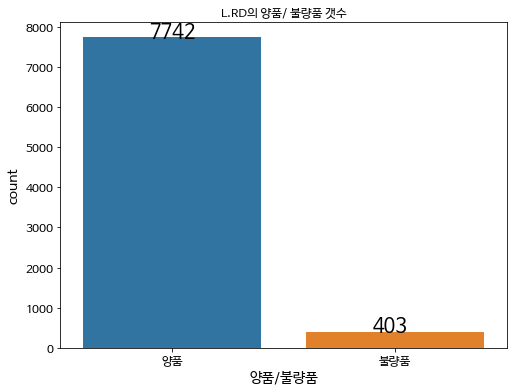

In [ ]:
show_one_labels_cnt(y_data_labels_5p)

## 4.훈련데이터와 테스트데이터 분리

In [ ]:
# MinMaxScaler로 데이터 스케일링한 피처를 사용
X_data = X_mm_VIF_scaled.copy()
all_data_5p_LRD = pd.concat([X_data, y_data_labels_5p.iloc[:,0]], axis=1)

X_train_5p, X_test_5p, y_train_5p, y_test_5p = train_test_split(X_data, y_data_labels_5p.iloc[:,0], 
                                                   test_size=0.2, random_state=42)
#훈련 데이터 와 테스트 데이터 비율 확인
print(y_train_5p.shape)
print(y_test_5p.shape)


#원본 데이터 와의 비율을 확인 
#원본 데이터의 비율에 맞춰서 샘플링 하는 것을 층화 표본 추출이라고 합니다.

#훈련 데이터의 레이블 비율 확인
print(y_train_5p.value_counts()/y_train_5p.count())
#테스트 데이터의 레이블 비율 확인
print(y_test_5p.value_counts()/y_test_5p.count())

(6516,)
(1629,)
0    0.95043
1    0.04957
Name: L.RD, dtype: float64
0    0.95089
1    0.04911
Name: L.RD, dtype: float64


- 데이터 shape확인

In [ ]:
print(X_train_5p.shape)
print(y_train_5p.shape)

(6516, 165)
(6516,)


## 5.RandomForest모델 훈련 및 검증

### 1) RandomForest모델 훈련

In [ ]:
rf_clf_5p = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf_5p.fit(X_train_5p, y_train_5p)
rf_predict_5p = rf_clf_5p.predict(X_test_5p)
rf_predict_proba_5p = rf_clf_5p.predict_proba(X_test_5p)[:,1]
get_clf_eval(y_test_5p, rf_predict_5p, rf_predict_proba_5p)

정확도: 0.9625537139349294
정밀도: 0.7435897435897436
재현율: 0.3625
F1: 0.4873949579831932
AUC: 0.9184151065203356


### 2) DecisionTree출력

In [ ]:
estimator_5p  = rf_clf_5p.estimators_[99]

# .dot 파일로 export 해줍니다
export_graphviz(estimator_5p,
                feature_names=X_train_5p.columns,
                out_file='bootstrapTrueMaxSamplesNone.dot',
                max_depth = 3, # 표현하고 싶은 최대 depth
                precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','bootstrapTrueMaxSamplesNone.dot', '-o', 'bootstrapTrueMaxSamplesNone.png', '-Gdpi=600'])

0

#### 위의 DecisionTree결과에서 samples와 value의 데이터 크기가 달라서 bootstrap설정을 false로 해봤는데 데이터의 크기는 같아졌으나 bootstrap=false를 하면 데이터 샘플링을 하지 않고 같은 데이터로 Decision Tree훈련을 하게 되므로 RandomForest훈련의 의미가 없어짐
```python
rf_clf_5p = RandomForestClassifier(random_state=42, n_jobs=-1, bootstrap=False)
rf_clf_5p.fit(X_train_5p, y_train_5p)
rf_predict_5p = rf_clf_5p.predict(X_test_5p)
rf_predict_proba_5p = rf_clf_5p.predict_proba(X_test_5p)[:,1]
get_clf_eval(y_test_5p, rf_predict_5p, rf_predict_proba_5p)
```

## max_samples를 float의 형태로 설정하면 데이터의 value데이터가 설정한 비율만큼 추출됨

```python
rf_clf_5p = RandomForestClassifier(random_state=42, n_jobs=-1, max_samples=0.5)
rf_clf_5p.fit(X_train_5p, y_train_5p)
rf_predict_5p = rf_clf_5p.predict(X_test_5p)
rf_predict_proba_5p = rf_clf_5p.predict_proba(X_test_5p)[:,1]
get_clf_eval(y_test_5p, rf_predict_5p, rf_predict_proba_5p)
```

### 3) 하이퍼파라미터 튜닝 전의 피처 중요도

SPOUT.LEFT.BOTTOM.1FI33513.PV          0.026935
D_AB7_L_UL                             0.025857
DB.HEAT.BTM.LEFT.1.TMP.1TI40315.PV     0.017402
ROOF.HT.BAY.9.TOTAL.PWR.1CLBAY9_CPV    0.017134
D_AB8_L_LR                             0.014954
D_AB8_U_LR                             0.014798
l_r_top_n.2                            0.013331
DB.HEAT.TOP.7.1.TMP.1TI40307.PV        0.012912
LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV    0.012840
D_AB6_U_LR                             0.012362
N2.TO.EA1313B.1FI33527A_PV             0.012101
N2.TO.EA1315A.1FI33504A_PV             0.011845
S_AB10_AB11_L_L                        0.011748
D_AB4_L_LR                             0.010850
S_AB4_AB5_U_L                          0.010785
D_AB8_L_UL                             0.010782
ATM.N2.H2.5..함유율.1CLFI33402_CPV        0.010511
D_AB3_L_UL                             0.010508
top_1                                  0.009961
TMP.GLASS..Z_RET.E1.1TI40241.PV        0.009897
ROOF.HT.BAY.3.TOTAL.PWR.1CLBAY3_CPV    0

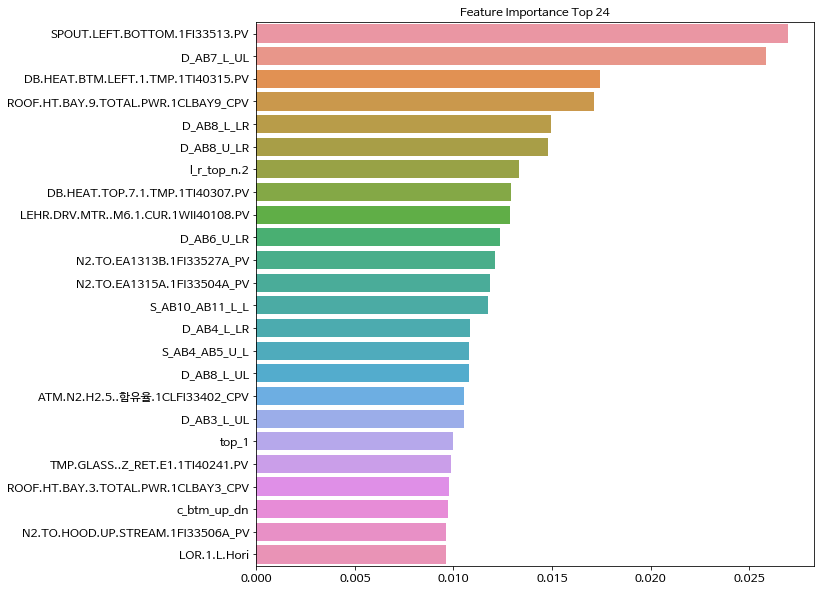

In [ ]:
ft_importance_values_5p = rf_clf_5p.feature_importances_
ft_series_5p = pd.Series(ft_importance_values_5p, index = X_train_5p.columns)
ft_top24 = ft_series_5p.sort_values(ascending=False)[:24]
print(ft_top24)
# 시각화
plt.figure(figsize=(10,10))
plt.title('Feature Importance Top 24')
sns.barplot(x=ft_top24, y=ft_top24.index)
plt.show()

### 피처중요도가 높은 5개의 피처와 레이블과의 분포그래프
- 일부는 잘 분류되는 것같음

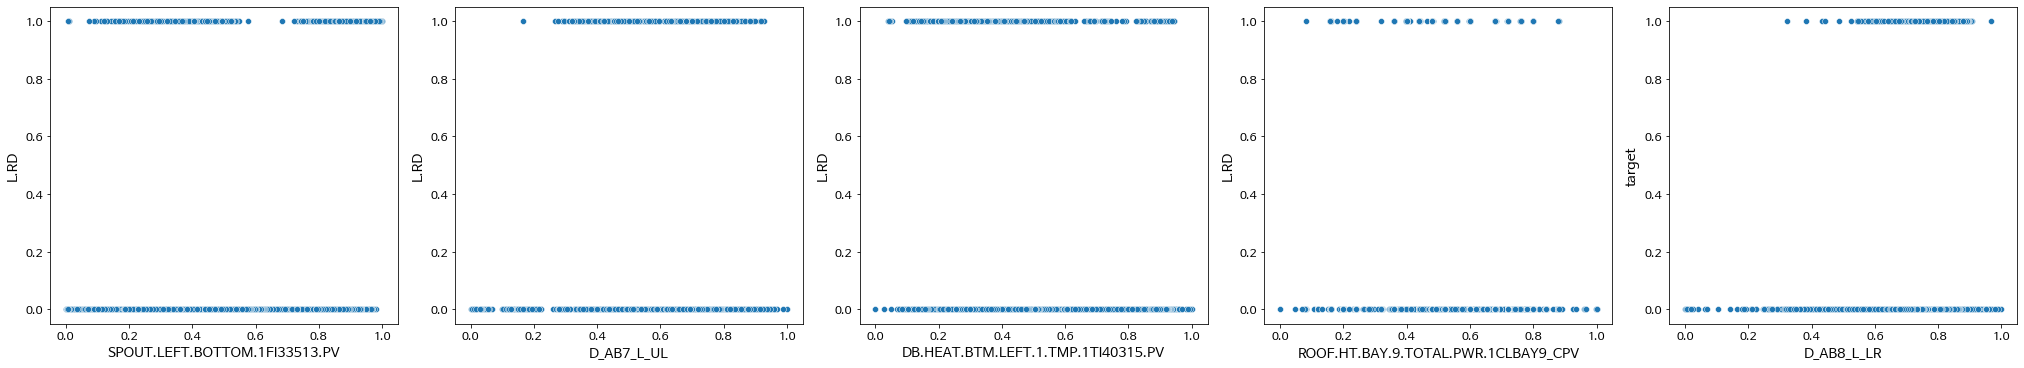

In [ ]:
show_feature_label(ft_top24, y_data_labels_5p)

## 6.하이퍼파라미터 튜닝

In [ ]:
params = {'n_estimators':[30, 50, 70, 100], 'max_depth':[15, 17, 19, 20], 
          'min_samples_leaf':[8, 12, 18], 'min_samples_split':[8, 20, 50, 100, 130]}

# cv를 5로 설정
# 재현율을 높이도록 하이퍼파라미터 튜닝
gridcv_5 = GridSearchCV(rf_clf_5p, param_grid = params, cv=5, n_jobs=-1, scoring='recall')
gridcv_5.fit(X_train_5p, y_train_5p)

### 1)하이퍼파라미터 튜닝으로 향상된 모델의 성능 평가

In [ ]:
rf_estimator_5p = gridcv_5.best_estimator_
print(rf_estimator_5p)

In [ ]:
rf_estimator_5p = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
rf_estimator_5p.fit(X_train_5p, y_train_5p)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
rf_predict_5p = rf_estimator_5p.predict(X_test_5p)
rf_predict_proba_5p = rf_estimator_5p.predict_proba(X_test_5p)[:,1]
get_clf_eval(y_test_5p, rf_predict_5p, rf_predict_proba_5p)

정확도: 0.958256599140577
정밀도: 0.6875
재현율: 0.275
F1: 0.3928571428571429
AUC: 0.9191010329244674


### 하이퍼파라미터 튜닝 후의 피처 중요도

SPOUT.LEFT.BOTTOM.1FI33513.PV          0.036230
D_AB7_L_UL                             0.034821
DB.HEAT.BTM.LEFT.1.TMP.1TI40315.PV     0.027143
ROOF.HT.BAY.9.TOTAL.PWR.1CLBAY9_CPV    0.024959
LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV    0.020291
N2.TO.EA1315A.1FI33504A_PV             0.019712
D_AB8_L_LR                             0.017219
ROOF.HEATING.Zone80.1JIC31180.PV       0.016822
D_AB8_L_UL                             0.016310
S_AB10_AB11_L_L                        0.016231
l_r_top_n.2                            0.013925
TMP.GLASS..Z_RET.E1.1TI40241.PV        0.013539
ATM.N2.H2.5..함유율.1CLFI33402_CPV        0.013022
D_AB4_L_LR                             0.012789
DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV     0.012484
N2.TO.EA1313A.1FI33503A_PV             0.012390
DB.HEAT.TOP.7.1.TMP.1TI40307.PV        0.012068
D_AB6_U_LR                             0.011754
c_btm_up_dn                            0.011593
N2.TO.EA1313B.1FI33527A_PV             0.011064
D_AB3_L_UL                             0

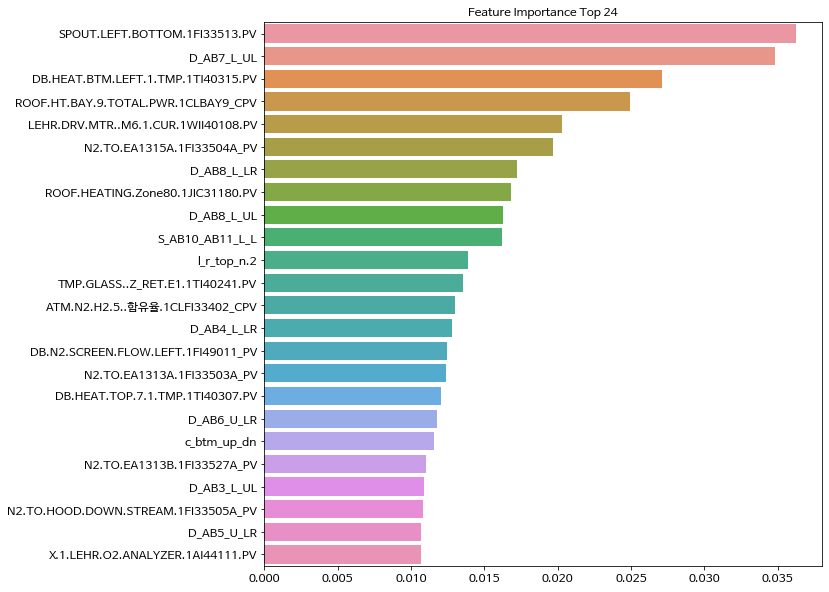

In [ ]:
ft_importance_values_5p = rf_estimator_5p.feature_importances_
ft_series_5p = pd.Series(ft_importance_values_5p, index = X_train_5p.columns)
ft_top24 = ft_series_5p.sort_values(ascending=False)[:24]
print(ft_top24)
# 시각화
plt.figure(figsize=(10,10))
plt.title('Feature Importance Top 24')
sns.barplot(x=ft_top24, y=ft_top24.index)
plt.show()